In [1633]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import scipy
# import tensorflow as tf
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow import keras
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [1634]:
df=pd.read_csv('/kaggle/input/titanic/train.csv')
dftest=pd.read_csv('/kaggle/input/titanic/test.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1635]:
df.shape

(891, 12)

In [1636]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [1637]:
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Data information
* Survived: 0 = No, 1 = Yes
* pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
* sibsp: # of siblings / spouses aboard the Titanic
* parch: # of parents / children aboard the Titanic
* ticket: Ticket number
* cabin: Cabin number
* embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton

## 1. Visualization

In [1638]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plots

In [1639]:
def bar_chart(feature):
    survived = df[df['Survived']==1][feature].value_counts()
    dead = df[df['Survived']==0][feature].value_counts()
    dfnew = pd.DataFrame([survived,dead])
    dfnew.index = ['Survived','Dead']
    dfnew.plot(kind='bar',stacked=False, figsize=(10,5))

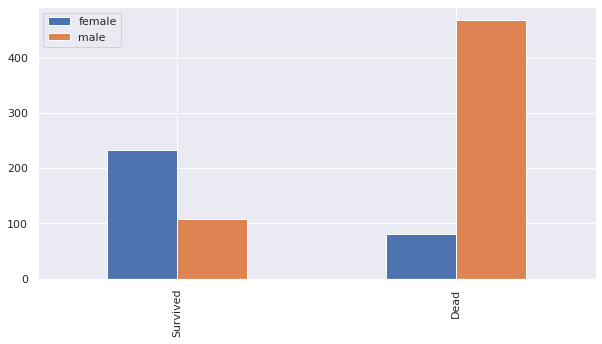

In [1640]:
bar_chart('Sex')

> It means female has more chance of survival

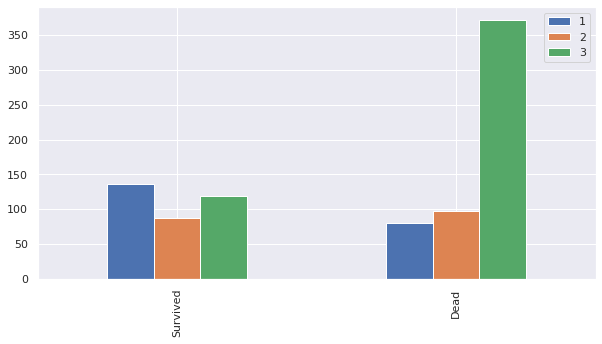

In [1641]:
bar_chart('Pclass')

> Pclass 3 has more chance of not surviving

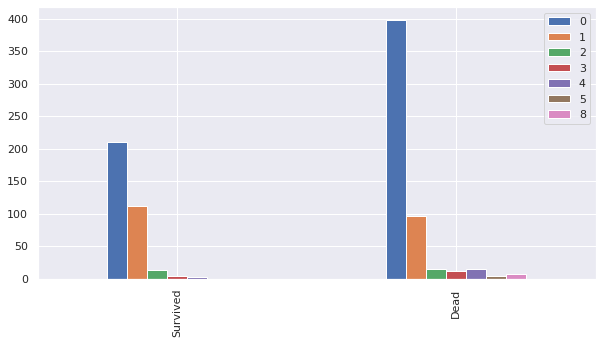

In [1642]:
bar_chart('SibSp')

> Having sibling or not doesnt matter much

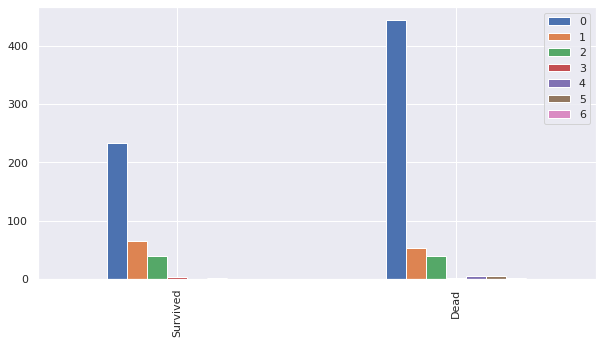

In [1643]:
bar_chart('Parch')

> Parch also doesnt reflect much

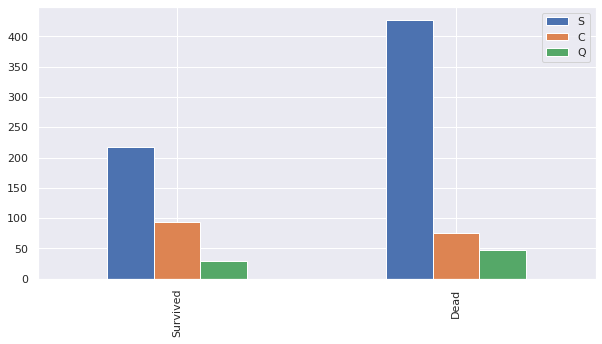

In [1644]:
bar_chart('Embarked')

> People from C are more likely to survive

## 2. Feature engineering and data cleaning

> We can remove some columns of less importance as cleaning them will not improve dataset much and is not worth giving time

In [1645]:
xtrain=df.drop(['PassengerId','Survived','Name','Ticket','Cabin'],axis=1)
xtest=dftest.drop(['PassengerId','Name','Ticket','Cabin'],axis=1)


In [1646]:
xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


* Points to note:
    * Embarkment in train data has null values
    * Fare in test data has null values
    * Age in both data has null values
    

In [1647]:
# first lets handle embarked for train set by converting its value to one-hot 
# we can neglect missing values of embarked of only 2 missing values

dummy=pd.get_dummies(xtrain['Embarked'])
xtrain=pd.concat([xtrain,dummy],axis=1)
xtrain.drop(['Embarked'],axis=1,inplace=True)
xtrain.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,male,22.0,1,0,7.2500,0,0,1
1,1,female,38.0,1,0,71.2833,1,0,0
2,3,female,26.0,0,0,7.9250,0,0,1
3,1,female,35.0,1,0,53.1000,0,0,1
4,3,male,35.0,0,0,8.0500,0,0,1


In [1648]:
# Now lets handle missing value of fare in test dataset by replacing with mean
mean=xtest['Fare'].mean()
print(mean)
Fare=xtest['Fare'].replace(np.NaN,mean)
xtest.drop(['Fare'],axis=1,inplace=True)
xtest=pd.concat([xtest,Fare],axis=1)
xtest.info()

35.6271884892086
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Embarked  418 non-null    object 
 6   Fare      418 non-null    float64
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


In [1649]:
# Now handle embarked for test set by converting its value to one-hot

dummy=pd.get_dummies(xtest['Embarked'])
xtest=pd.concat([xtest,dummy],axis=1)
xtest.drop(['Embarked'],axis=1,inplace=True)
xtest.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,C,Q,S
0,3,male,34.5,0,0,7.8292,0,1,0
1,3,female,47.0,1,0,7.0000,0,0,1
2,2,male,62.0,0,0,9.6875,0,1,0
3,3,male,27.0,0,0,8.6625,0,0,1
4,3,female,22.0,1,1,12.2875,0,0,1


In [1650]:
# Now lets handle missing value of Age of both dataset by replacing with mean
#train
mean=xtrain['Age'].mean()
print(mean)
newage=xtrain['Age'].replace(np.nan,mean)
xtrain.drop(['Age'],axis=1,inplace=True)
xtrain=pd.concat([xtrain,newage],axis=1)
#test
mean2=xtest['Age'].mean()
print(mean2)
newage2=xtest['Age'].replace(np.nan,mean)
xtest.drop(['Age'],axis=1,inplace=True)
xtest=pd.concat([xtest,newage2],axis=1)

29.69911764705882
30.272590361445783


In [1651]:
xtrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  891 non-null    int64  
 1   Sex     891 non-null    object 
 2   SibSp   891 non-null    int64  
 3   Parch   891 non-null    int64  
 4   Fare    891 non-null    float64
 5   C       891 non-null    uint8  
 6   Q       891 non-null    uint8  
 7   S       891 non-null    uint8  
 8   Age     891 non-null    float64
dtypes: float64(2), int64(3), object(1), uint8(3)
memory usage: 44.5+ KB


In [1652]:
xtrain.head()

,Pclass,Sex,SibSp,Parch,Fare,C,Q,S,Age
0,3,male,1,0,7.2500,0,0,1,22.0
1,1,female,1,0,71.2833,1,0,0,38.0
2,3,female,0,0,7.9250,0,0,1,26.0
3,1,female,1,0,53.1000,0,0,1,35.0
4,3,male,0,0,8.0500,0,0,1,35.0


In [1653]:
#Now lets convert Sex to one-hot 
#train
dummy=pd.get_dummies(xtrain['Sex'])
xtrain=pd.concat([xtrain,dummy],axis=1)
xtrain.drop(['Sex'],axis=1,inplace=True)
#test
dummy2=pd.get_dummies(xtest['Sex'])
xtest=pd.concat([xtest,dummy2],axis=1)
xtest.drop(['Sex'],axis=1,inplace=True)

In [1654]:
xtrain.head()

,Pclass,SibSp,Parch,Fare,C,Q,S,Age,female,male
0,3,1,0,7.2500,0,0,1,22.0,0,1
1,1,1,0,71.2833,1,0,0,38.0,1,0
2,3,0,0,7.9250,0,0,1,26.0,1,0
3,1,1,0,53.1000,0,0,1,35.0,1,0
4,3,0,0,8.0500,0,0,1,35.0,0,1


In [1655]:
xtest.head()

,Pclass,SibSp,Parch,Fare,C,Q,S,Age,female,male
0,3,0,0,7.8292,0,1,0,34.5,0,1
1,3,1,0,7.0000,0,0,1,47.0,1,0
2,2,0,0,9.6875,0,1,0,62.0,0,1
3,3,0,0,8.6625,0,0,1,27.0,0,1
4,3,1,1,12.2875,0,0,1,22.0,1,0


It was seen that including fare is making bad predictions so remove it

In [1656]:
xtrain=xtrain.drop(['Fare'],axis=1)
xtest=xtest.drop(['Fare'],axis=1)
xtrain.head()

,Pclass,SibSp,Parch,C,Q,S,Age,female,male
0,3,1,0,0,0,1,22.0,0,1
1,1,1,0,1,0,0,38.0,1,0
2,3,0,0,0,0,1,26.0,1,0
3,1,1,0,0,0,1,35.0,1,0
4,3,0,0,0,0,1,35.0,0,1


> Data cleaning is done now extract ytrain from datset

In [1657]:
#taking y from original datset and converting to numpy array
ytrain=pd.DataFrame(df['Survived']).values
print(ytrain.shape)

(891, 1)


In [1658]:
# COnverting Xtrain and xtest to numpy arrays fr further analysis
xtrain=xtrain.values
xtest=xtest.values

In [1659]:
xtrain.shape

(891, 9)

In [1660]:
print(xtrain)

[[ 3.          1.          0.         ... 22.          0.
   1.        ]
 [ 1.          1.          0.         ... 38.          1.
   0.        ]
 [ 3.          0.          0.         ... 26.          1.
   0.        ]
 ...
 [ 3.          1.          2.         ... 29.69911765  1.
   0.        ]
 [ 1.          0.          0.         ... 26.          0.
   1.        ]
 [ 3.          0.          0.         ... 32.          0.
   1.        ]]


 ## 3. Making 4 layer deep logistic layer using keras

In [1661]:
# define the keras model
model = Sequential()
model.add(Dense(25, input_dim=9, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [1662]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_185 (Dense)            (None, 25)                250       
_________________________________________________________________
dense_186 (Dense)            (None, 12)                312       
_________________________________________________________________
dense_187 (Dense)            (None, 8)                 104       
_________________________________________________________________
dense_188 (Dense)            (None, 1)                 9         
Total params: 675
Trainable params: 675
Non-trainable params: 0
_________________________________________________________________


In [1663]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [1664]:
#let it be batch gradient descent
model.fit(xtrain, ytrain, epochs=10000, batch_size=891)

Epoch 1/5000
891/891 [==============================] - 0s 200us/step - loss: 2.0905 - accuracy: 0.3838
Epoch 2/5000
891/891 [==============================] - 0s 12us/step - loss: 1.7065 - accuracy: 0.3850
Epoch 3/5000
891/891 [==============================] - 0s 11us/step - loss: 1.4670 - accuracy: 0.3872
Epoch 4/5000
891/891 [==============================] - 0s 12us/step - loss: 1.2369 - accuracy: 0.3917
Epoch 5/5000
891/891 [==============================] - 0s 11us/step - loss: 1.0706 - accuracy: 0.3872
Epoch 6/5000
891/891 [==============================] - 0s 11us/step - loss: 0.9526 - accuracy: 0.3895
Epoch 7/5000
891/891 [==============================] - 0s 12us/step - loss: 0.8722 - accuracy: 0.3883
Epoch 8/5000
891/891 [==============================] - 0s 12us/step - loss: 0.8106 - accuracy: 0.3928
Epoch 9/5000
891/891 [==============================] - 0s 13us/step - loss: 0.7620 - accuracy: 0.3939
Epoch 10/5000
891/891 [==============================] - 0s 10us/step - 

891/891 [==============================] - 0s 12us/step - loss: 0.4265 - accuracy: 0.8316
Epoch 80/5000
891/891 [==============================] - 0s 11us/step - loss: 0.4216 - accuracy: 0.8227
Epoch 81/5000
891/891 [==============================] - 0s 13us/step - loss: 0.4238 - accuracy: 0.8249
Epoch 82/5000
891/891 [==============================] - 0s 12us/step - loss: 0.4216 - accuracy: 0.8294
Epoch 83/5000
891/891 [==============================] - 0s 11us/step - loss: 0.4202 - accuracy: 0.8260
Epoch 84/5000
891/891 [==============================] - 0s 13us/step - loss: 0.4186 - accuracy: 0.8316
Epoch 85/5000
891/891 [==============================] - 0s 12us/step - loss: 0.4210 - accuracy: 0.8305
Epoch 86/5000
891/891 [==============================] - 0s 12us/step - loss: 0.4158 - accuracy: 0.8283
Epoch 87/5000
891/891 [==============================] - 0s 11us/step - loss: 0.4164 - accuracy: 0.8260
Epoch 88/5000
891/891 [==============================] - 0s 11us/step - loss: 

891/891 [==============================] - 0s 11us/step - loss: 0.3929 - accuracy: 0.8350
Epoch 158/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3950 - accuracy: 0.8328
Epoch 159/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3924 - accuracy: 0.8260
Epoch 160/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3947 - accuracy: 0.8272
Epoch 161/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3972 - accuracy: 0.8294
Epoch 162/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3981 - accuracy: 0.8294
Epoch 163/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3959 - accuracy: 0.8384
Epoch 164/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3929 - accuracy: 0.8272
Epoch 165/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3999 - accuracy: 0.8316
Epoch 166/5000
891/891 [==============================] - 0s 12us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3978 - accuracy: 0.8238
Epoch 236/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3900 - accuracy: 0.8384
Epoch 237/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3911 - accuracy: 0.8305
Epoch 238/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3886 - accuracy: 0.8350
Epoch 239/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3878 - accuracy: 0.8350
Epoch 240/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3915 - accuracy: 0.8328
Epoch 241/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3840 - accuracy: 0.8406
Epoch 242/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3862 - accuracy: 0.8294
Epoch 243/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3870 - accuracy: 0.8361
Epoch 244/5000
891/891 [==============================] - 0s 11us/step

891/891 [==============================] - 0s 12us/step - loss: 0.3826 - accuracy: 0.8373
Epoch 314/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3805 - accuracy: 0.8440
Epoch 315/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3834 - accuracy: 0.8384
Epoch 316/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3837 - accuracy: 0.8384
Epoch 317/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3821 - accuracy: 0.8283
Epoch 318/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3809 - accuracy: 0.8361
Epoch 319/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3818 - accuracy: 0.8361
Epoch 320/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3808 - accuracy: 0.8384
Epoch 321/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3843 - accuracy: 0.8384
Epoch 322/5000
891/891 [==============================] - 0s 11us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3780 - accuracy: 0.8328
Epoch 391/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3795 - accuracy: 0.8429
Epoch 392/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3790 - accuracy: 0.8406
Epoch 393/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3780 - accuracy: 0.8395
Epoch 394/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3777 - accuracy: 0.8350
Epoch 395/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3791 - accuracy: 0.8406
Epoch 396/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3804 - accuracy: 0.8361
Epoch 397/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3812 - accuracy: 0.8406
Epoch 398/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3809 - accuracy: 0.8440
Epoch 399/5000
891/891 [==============================] - 0s 11us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3793 - accuracy: 0.8395
Epoch 469/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3797 - accuracy: 0.8373
Epoch 470/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3805 - accuracy: 0.8373
Epoch 471/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3741 - accuracy: 0.8384
Epoch 472/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3833 - accuracy: 0.8418
Epoch 473/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3762 - accuracy: 0.8395
Epoch 474/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3762 - accuracy: 0.8373
Epoch 475/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3891 - accuracy: 0.8395
Epoch 476/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3779 - accuracy: 0.8361
Epoch 477/5000
891/891 [==============================] - 0s 11us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3763 - accuracy: 0.8440
Epoch 547/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3730 - accuracy: 0.8361
Epoch 548/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3755 - accuracy: 0.8429
Epoch 549/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3727 - accuracy: 0.8462
Epoch 550/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3734 - accuracy: 0.8406
Epoch 551/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3738 - accuracy: 0.8406
Epoch 552/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3756 - accuracy: 0.8395
Epoch 553/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3730 - accuracy: 0.8429
Epoch 554/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3763 - accuracy: 0.8283
Epoch 555/5000
891/891 [==============================] - 0s 10us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3709 - accuracy: 0.8373
Epoch 625/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3730 - accuracy: 0.8429
Epoch 626/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3751 - accuracy: 0.8440
Epoch 627/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3720 - accuracy: 0.8474
Epoch 628/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3711 - accuracy: 0.8440
Epoch 629/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3734 - accuracy: 0.8429
Epoch 630/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3704 - accuracy: 0.8462
Epoch 631/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3702 - accuracy: 0.8429
Epoch 632/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3718 - accuracy: 0.8429
Epoch 633/5000
891/891 [==============================] - 0s 11us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3703 - accuracy: 0.8507
Epoch 703/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3691 - accuracy: 0.8530
Epoch 704/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3693 - accuracy: 0.8474
Epoch 705/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3726 - accuracy: 0.8384
Epoch 706/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3720 - accuracy: 0.8451
Epoch 707/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3716 - accuracy: 0.8406
Epoch 708/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3736 - accuracy: 0.8361
Epoch 709/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3695 - accuracy: 0.8418
Epoch 710/5000
891/891 [==============================] - 0s 16us/step - loss: 0.3692 - accuracy: 0.8395
Epoch 711/5000
891/891 [==============================] - 0s 15us/step

891/891 [==============================] - 0s 12us/step - loss: 0.3681 - accuracy: 0.8474
Epoch 781/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3674 - accuracy: 0.8496
Epoch 782/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3690 - accuracy: 0.8451
Epoch 783/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3700 - accuracy: 0.8384
Epoch 784/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3705 - accuracy: 0.8373
Epoch 785/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3683 - accuracy: 0.8451
Epoch 786/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3671 - accuracy: 0.8418
Epoch 787/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3694 - accuracy: 0.8429
Epoch 788/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3696 - accuracy: 0.8418
Epoch 789/5000
891/891 [==============================] - 0s 12us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3676 - accuracy: 0.8462
Epoch 859/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3690 - accuracy: 0.8429
Epoch 860/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3675 - accuracy: 0.8440
Epoch 861/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3680 - accuracy: 0.8429
Epoch 862/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3684 - accuracy: 0.8485
Epoch 863/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3681 - accuracy: 0.8462
Epoch 864/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3669 - accuracy: 0.8462
Epoch 865/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3674 - accuracy: 0.8429
Epoch 866/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3690 - accuracy: 0.8406
Epoch 867/5000
891/891 [==============================] - 0s 12us/step

891/891 [==============================] - 0s 10us/step - loss: 0.3702 - accuracy: 0.8429
Epoch 937/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3666 - accuracy: 0.8507
Epoch 938/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3663 - accuracy: 0.8406
Epoch 939/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3669 - accuracy: 0.8418
Epoch 940/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3656 - accuracy: 0.8451
Epoch 941/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3642 - accuracy: 0.8440
Epoch 942/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3654 - accuracy: 0.8474
Epoch 943/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3662 - accuracy: 0.8496
Epoch 944/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3658 - accuracy: 0.8496
Epoch 945/5000
891/891 [==============================] - 0s 10us/step

891/891 [==============================] - 0s 11us/step - loss: 0.3808 - accuracy: 0.8350
Epoch 1015/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3705 - accuracy: 0.8440
Epoch 1016/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3689 - accuracy: 0.8429
Epoch 1017/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3724 - accuracy: 0.8451
Epoch 1018/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3690 - accuracy: 0.8429
Epoch 1019/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3723 - accuracy: 0.8429
Epoch 1020/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3642 - accuracy: 0.8429
Epoch 1021/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3645 - accuracy: 0.8429
Epoch 1022/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3670 - accuracy: 0.8440
Epoch 1023/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3629 - accuracy: 0.8462
Epoch 1092/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3634 - accuracy: 0.8485
Epoch 1093/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3631 - accuracy: 0.8519
Epoch 1094/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3640 - accuracy: 0.8474
Epoch 1095/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3654 - accuracy: 0.8474
Epoch 1096/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3643 - accuracy: 0.8474
Epoch 1097/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3633 - accuracy: 0.8451
Epoch 1098/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3659 - accuracy: 0.8462
Epoch 1099/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3655 - accuracy: 0.8440
Epoch 1100/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3647 - accuracy: 0.8474
Epoch 1169/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3630 - accuracy: 0.8485
Epoch 1170/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3635 - accuracy: 0.8474
Epoch 1171/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3644 - accuracy: 0.8429
Epoch 1172/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3641 - accuracy: 0.8519
Epoch 1173/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3622 - accuracy: 0.8462
Epoch 1174/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3650 - accuracy: 0.8440
Epoch 1175/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3628 - accuracy: 0.8451
Epoch 1176/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3617 - accuracy: 0.8507
Epoch 1177/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3633 - accuracy: 0.8440
Epoch 1246/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3623 - accuracy: 0.8496
Epoch 1247/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3643 - accuracy: 0.8395
Epoch 1248/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3625 - accuracy: 0.8440
Epoch 1249/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3607 - accuracy: 0.8575
Epoch 1250/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3637 - accuracy: 0.8462
Epoch 1251/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3672 - accuracy: 0.8395
Epoch 1252/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3659 - accuracy: 0.8429
Epoch 1253/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3610 - accuracy: 0.8474
Epoch 1254/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3599 - accuracy: 0.8485
Epoch 1323/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3613 - accuracy: 0.8485
Epoch 1324/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3608 - accuracy: 0.8507
Epoch 1325/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3642 - accuracy: 0.8462
Epoch 1326/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3606 - accuracy: 0.8519
Epoch 1327/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3644 - accuracy: 0.8406
Epoch 1328/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3594 - accuracy: 0.8485
Epoch 1329/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3672 - accuracy: 0.8384
Epoch 1330/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3647 - accuracy: 0.8474
Epoch 1331/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3689 - accuracy: 0.8440
Epoch 1400/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3693 - accuracy: 0.8406
Epoch 1401/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3704 - accuracy: 0.8418
Epoch 1402/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3643 - accuracy: 0.8395
Epoch 1403/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3610 - accuracy: 0.8507
Epoch 1404/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3630 - accuracy: 0.8496
Epoch 1405/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3592 - accuracy: 0.8474
Epoch 1406/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3605 - accuracy: 0.8496
Epoch 1407/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3605 - accuracy: 0.8496
Epoch 1408/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3664 - accuracy: 0.8429
Epoch 1477/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3616 - accuracy: 0.8474
Epoch 1478/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3628 - accuracy: 0.8474
Epoch 1479/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3617 - accuracy: 0.8474
Epoch 1480/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3626 - accuracy: 0.8474
Epoch 1481/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3608 - accuracy: 0.8474
Epoch 1482/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3619 - accuracy: 0.8530
Epoch 1483/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3611 - accuracy: 0.8485
Epoch 1484/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3617 - accuracy: 0.8530
Epoch 1485/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3605 - accuracy: 0.8496
Epoch 1554/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3613 - accuracy: 0.8485
Epoch 1555/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3612 - accuracy: 0.8496
Epoch 1556/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3598 - accuracy: 0.8451
Epoch 1557/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3593 - accuracy: 0.8474
Epoch 1558/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3607 - accuracy: 0.8462
Epoch 1559/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3600 - accuracy: 0.8474
Epoch 1560/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3613 - accuracy: 0.8496
Epoch 1561/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3577 - accuracy: 0.8507
Epoch 1562/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3587 - accuracy: 0.8552
Epoch 1631/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3587 - accuracy: 0.8541
Epoch 1632/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3611 - accuracy: 0.8451
Epoch 1633/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3626 - accuracy: 0.8429
Epoch 1634/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3581 - accuracy: 0.8496
Epoch 1635/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3591 - accuracy: 0.8474
Epoch 1636/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3597 - accuracy: 0.8474
Epoch 1637/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3586 - accuracy: 0.8485
Epoch 1638/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3590 - accuracy: 0.8451
Epoch 1639/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3572 - accuracy: 0.8462
Epoch 1708/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3597 - accuracy: 0.8462
Epoch 1709/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3570 - accuracy: 0.8519
Epoch 1710/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3604 - accuracy: 0.8485
Epoch 1711/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3584 - accuracy: 0.8496
Epoch 1712/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3571 - accuracy: 0.8519
Epoch 1713/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3581 - accuracy: 0.8451
Epoch 1714/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3578 - accuracy: 0.8519
Epoch 1715/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3594 - accuracy: 0.8541
Epoch 1716/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3617 - accuracy: 0.8451
Epoch 1785/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3562 - accuracy: 0.8485
Epoch 1786/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3568 - accuracy: 0.8496
Epoch 1787/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3606 - accuracy: 0.8485
Epoch 1788/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3593 - accuracy: 0.8440
Epoch 1789/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3576 - accuracy: 0.8541
Epoch 1790/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3610 - accuracy: 0.8440
Epoch 1791/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3569 - accuracy: 0.8496
Epoch 1792/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3613 - accuracy: 0.8451
Epoch 1793/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3557 - accuracy: 0.8507
Epoch 1862/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3573 - accuracy: 0.8496
Epoch 1863/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3561 - accuracy: 0.8563
Epoch 1864/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3578 - accuracy: 0.8440
Epoch 1865/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3579 - accuracy: 0.8395
Epoch 1866/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3566 - accuracy: 0.8485
Epoch 1867/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3563 - accuracy: 0.8530
Epoch 1868/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3586 - accuracy: 0.8451
Epoch 1869/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3593 - accuracy: 0.8451
Epoch 1870/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3546 - accuracy: 0.8563
Epoch 1939/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3571 - accuracy: 0.8462
Epoch 1940/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3548 - accuracy: 0.8575
Epoch 1941/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3552 - accuracy: 0.8485
Epoch 1942/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3571 - accuracy: 0.8530
Epoch 1943/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3575 - accuracy: 0.8507
Epoch 1944/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3554 - accuracy: 0.8541
Epoch 1945/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3557 - accuracy: 0.8552
Epoch 1946/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3567 - accuracy: 0.8519
Epoch 1947/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 14us/step - loss: 0.3608 - accuracy: 0.8418
Epoch 2016/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3590 - accuracy: 0.8440
Epoch 2017/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3681 - accuracy: 0.8462
Epoch 2018/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3551 - accuracy: 0.8530
Epoch 2019/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3577 - accuracy: 0.8496
Epoch 2020/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3598 - accuracy: 0.8485
Epoch 2021/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3601 - accuracy: 0.8474
Epoch 2022/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3554 - accuracy: 0.8496
Epoch 2023/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3553 - accuracy: 0.8474
Epoch 2024/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3604 - accuracy: 0.8462
Epoch 2093/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3582 - accuracy: 0.8451
Epoch 2094/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3576 - accuracy: 0.8496
Epoch 2095/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3552 - accuracy: 0.8541
Epoch 2096/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3582 - accuracy: 0.8507
Epoch 2097/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3584 - accuracy: 0.8440
Epoch 2098/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3534 - accuracy: 0.8485
Epoch 2099/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3587 - accuracy: 0.8474
Epoch 2100/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3577 - accuracy: 0.8541
Epoch 2101/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3600 - accuracy: 0.8474
Epoch 2170/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3551 - accuracy: 0.8496
Epoch 2171/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3615 - accuracy: 0.8485
Epoch 2172/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3545 - accuracy: 0.8485
Epoch 2173/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3546 - accuracy: 0.8519
Epoch 2174/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3547 - accuracy: 0.8597
Epoch 2175/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3544 - accuracy: 0.8507
Epoch 2176/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3575 - accuracy: 0.8519
Epoch 2177/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3538 - accuracy: 0.8507
Epoch 2178/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3551 - accuracy: 0.8507
Epoch 2247/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3533 - accuracy: 0.8485
Epoch 2248/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3561 - accuracy: 0.8563
Epoch 2249/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3542 - accuracy: 0.8474
Epoch 2250/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3542 - accuracy: 0.8519
Epoch 2251/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3541 - accuracy: 0.8530
Epoch 2252/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3537 - accuracy: 0.8519
Epoch 2253/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3544 - accuracy: 0.8496
Epoch 2254/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3565 - accuracy: 0.8530
Epoch 2255/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3544 - accuracy: 0.8496
Epoch 2323/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3532 - accuracy: 0.8575
Epoch 2324/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3551 - accuracy: 0.8586
Epoch 2325/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3541 - accuracy: 0.8496
Epoch 2326/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3523 - accuracy: 0.8496
Epoch 2327/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3534 - accuracy: 0.8563
Epoch 2328/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3582 - accuracy: 0.8519
Epoch 2329/5000
891/891 [==============================] - 0s 17us/step - loss: 0.3546 - accuracy: 0.8552
Epoch 2330/5000
891/891 [==============================] - 0s 17us/step - loss: 0.3551 - accuracy: 0.8519
Epoch 2331/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3535 - accuracy: 0.8474
Epoch 2400/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3591 - accuracy: 0.8552
Epoch 2401/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3553 - accuracy: 0.8530
Epoch 2402/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3530 - accuracy: 0.8552
Epoch 2403/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3567 - accuracy: 0.8474
Epoch 2404/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3547 - accuracy: 0.8496
Epoch 2405/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3536 - accuracy: 0.8552
Epoch 2406/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3528 - accuracy: 0.8530
Epoch 2407/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3530 - accuracy: 0.8485
Epoch 2408/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3546 - accuracy: 0.8519
Epoch 2477/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3536 - accuracy: 0.8440
Epoch 2478/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3576 - accuracy: 0.8485
Epoch 2479/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3534 - accuracy: 0.8552
Epoch 2480/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3567 - accuracy: 0.8485
Epoch 2481/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3526 - accuracy: 0.8575
Epoch 2482/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3525 - accuracy: 0.8507
Epoch 2483/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3579 - accuracy: 0.8429
Epoch 2484/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3536 - accuracy: 0.8485
Epoch 2485/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3544 - accuracy: 0.8384
Epoch 2554/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3533 - accuracy: 0.8530
Epoch 2555/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3621 - accuracy: 0.8485
Epoch 2556/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3596 - accuracy: 0.8451
Epoch 2557/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3482 - accuracy: 0.8530
Epoch 2558/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3605 - accuracy: 0.8429
Epoch 2559/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3550 - accuracy: 0.8496
Epoch 2560/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3528 - accuracy: 0.8496
Epoch 2561/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3555 - accuracy: 0.8530
Epoch 2562/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3580 - accuracy: 0.8451
Epoch 2631/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3509 - accuracy: 0.8519
Epoch 2632/5000
891/891 [==============================] - 0s 16us/step - loss: 0.3543 - accuracy: 0.8451
Epoch 2633/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3530 - accuracy: 0.8485
Epoch 2634/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3593 - accuracy: 0.8462
Epoch 2635/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3509 - accuracy: 0.8496
Epoch 2636/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3513 - accuracy: 0.8519
Epoch 2637/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3516 - accuracy: 0.8552
Epoch 2638/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3527 - accuracy: 0.8541
Epoch 2639/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3508 - accuracy: 0.8541
Epoch 2708/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3518 - accuracy: 0.8552
Epoch 2709/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3558 - accuracy: 0.8507
Epoch 2710/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3539 - accuracy: 0.8496
Epoch 2711/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3544 - accuracy: 0.8496
Epoch 2712/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3516 - accuracy: 0.8496
Epoch 2713/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3520 - accuracy: 0.8530
Epoch 2714/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3534 - accuracy: 0.8519
Epoch 2715/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3558 - accuracy: 0.8440
Epoch 2716/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3601 - accuracy: 0.8519
Epoch 2785/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3554 - accuracy: 0.8485
Epoch 2786/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3566 - accuracy: 0.8440
Epoch 2787/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3514 - accuracy: 0.8530
Epoch 2788/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3556 - accuracy: 0.8474
Epoch 2789/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3554 - accuracy: 0.8519
Epoch 2790/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3529 - accuracy: 0.8485
Epoch 2791/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3524 - accuracy: 0.8462
Epoch 2792/5000
891/891 [==============================] - 0s 9us/step - loss: 0.3536 - accuracy: 0.8519
Epoch 2793/5000
891/891 [==============================] - 0s 1

891/891 [==============================] - 0s 11us/step - loss: 0.3507 - accuracy: 0.8474
Epoch 2862/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3521 - accuracy: 0.8496
Epoch 2863/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3524 - accuracy: 0.8451
Epoch 2864/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3512 - accuracy: 0.8541
Epoch 2865/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3522 - accuracy: 0.8485
Epoch 2866/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3511 - accuracy: 0.8485
Epoch 2867/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3504 - accuracy: 0.8541
Epoch 2868/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3500 - accuracy: 0.8563
Epoch 2869/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3502 - accuracy: 0.8519
Epoch 2870/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3528 - accuracy: 0.8485
Epoch 2939/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3537 - accuracy: 0.8519
Epoch 2940/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3508 - accuracy: 0.8519
Epoch 2941/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3489 - accuracy: 0.8597
Epoch 2942/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3508 - accuracy: 0.8507
Epoch 2943/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3500 - accuracy: 0.8552
Epoch 2944/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3508 - accuracy: 0.8507
Epoch 2945/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3511 - accuracy: 0.8530
Epoch 2946/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3512 - accuracy: 0.8530
Epoch 2947/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3528 - accuracy: 0.8541
Epoch 3016/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3568 - accuracy: 0.8474
Epoch 3017/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3537 - accuracy: 0.8575
Epoch 3018/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3497 - accuracy: 0.8552
Epoch 3019/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3517 - accuracy: 0.8530
Epoch 3020/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3515 - accuracy: 0.8485
Epoch 3021/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3497 - accuracy: 0.8541
Epoch 3022/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3511 - accuracy: 0.8519
Epoch 3023/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3498 - accuracy: 0.8485
Epoch 3024/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3514 - accuracy: 0.8496
Epoch 3093/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3516 - accuracy: 0.8519
Epoch 3094/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3497 - accuracy: 0.8541
Epoch 3095/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3588 - accuracy: 0.8519
Epoch 3096/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3613 - accuracy: 0.8406
Epoch 3097/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3560 - accuracy: 0.8519
Epoch 3098/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3688 - accuracy: 0.8272
Epoch 3099/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3615 - accuracy: 0.8552
Epoch 3100/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3496 - accuracy: 0.8608
Epoch 3101/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3535 - accuracy: 0.8519
Epoch 3169/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3510 - accuracy: 0.8496
Epoch 3170/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3486 - accuracy: 0.8552
Epoch 3171/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3491 - accuracy: 0.8586
Epoch 3172/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3549 - accuracy: 0.8496
Epoch 3173/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3515 - accuracy: 0.8485
Epoch 3174/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3506 - accuracy: 0.8530
Epoch 3175/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3498 - accuracy: 0.8541
Epoch 3176/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3520 - accuracy: 0.8530
Epoch 3177/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3483 - accuracy: 0.8563
Epoch 3246/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3487 - accuracy: 0.8519
Epoch 3247/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3524 - accuracy: 0.8563
Epoch 3248/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3527 - accuracy: 0.8507
Epoch 3249/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3520 - accuracy: 0.8496
Epoch 3250/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3473 - accuracy: 0.8541
Epoch 3251/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3481 - accuracy: 0.8563
Epoch 3252/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3480 - accuracy: 0.8563
Epoch 3253/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3517 - accuracy: 0.8507
Epoch 3254/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3491 - accuracy: 0.8507
Epoch 3323/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3486 - accuracy: 0.8608
Epoch 3324/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3480 - accuracy: 0.8541
Epoch 3325/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3491 - accuracy: 0.8530
Epoch 3326/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3557 - accuracy: 0.8485
Epoch 3327/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3524 - accuracy: 0.8496
Epoch 3328/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3482 - accuracy: 0.8563
Epoch 3329/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3504 - accuracy: 0.8530
Epoch 3330/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3489 - accuracy: 0.8563
Epoch 3331/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3587 - accuracy: 0.8507
Epoch 3400/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3605 - accuracy: 0.8507
Epoch 3401/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3510 - accuracy: 0.8485
Epoch 3402/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3543 - accuracy: 0.8586
Epoch 3403/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3516 - accuracy: 0.8462
Epoch 3404/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3479 - accuracy: 0.8563
Epoch 3405/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3486 - accuracy: 0.8496
Epoch 3406/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3488 - accuracy: 0.8552
Epoch 3407/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3480 - accuracy: 0.8575
Epoch 3408/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3478 - accuracy: 0.8552
Epoch 3477/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3494 - accuracy: 0.8552
Epoch 3478/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3465 - accuracy: 0.8608
Epoch 3479/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3496 - accuracy: 0.8586
Epoch 3480/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3531 - accuracy: 0.8519
Epoch 3481/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3507 - accuracy: 0.8496
Epoch 3482/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3458 - accuracy: 0.8563
Epoch 3483/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3506 - accuracy: 0.8541
Epoch 3484/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3489 - accuracy: 0.8597
Epoch 3485/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3529 - accuracy: 0.8563
Epoch 3554/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3498 - accuracy: 0.8507
Epoch 3555/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3460 - accuracy: 0.8575
Epoch 3556/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3481 - accuracy: 0.8608
Epoch 3557/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3488 - accuracy: 0.8530
Epoch 3558/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3495 - accuracy: 0.8608
Epoch 3559/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3485 - accuracy: 0.8575
Epoch 3560/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3487 - accuracy: 0.8563
Epoch 3561/5000
891/891 [==============================] - 0s 15us/step - loss: 0.3516 - accuracy: 0.8563
Epoch 3562/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3481 - accuracy: 0.8563
Epoch 3631/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3479 - accuracy: 0.8552
Epoch 3632/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3454 - accuracy: 0.8620
Epoch 3633/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3495 - accuracy: 0.8541
Epoch 3634/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3496 - accuracy: 0.8575
Epoch 3635/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3561 - accuracy: 0.8519
Epoch 3636/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3581 - accuracy: 0.8395
Epoch 3637/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3575 - accuracy: 0.8474
Epoch 3638/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3464 - accuracy: 0.8485
Epoch 3639/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3483 - accuracy: 0.8608
Epoch 3708/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3540 - accuracy: 0.8519
Epoch 3709/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3483 - accuracy: 0.8620
Epoch 3710/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3475 - accuracy: 0.8575
Epoch 3711/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3497 - accuracy: 0.8507
Epoch 3712/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3504 - accuracy: 0.8563
Epoch 3713/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3553 - accuracy: 0.8530
Epoch 3714/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3512 - accuracy: 0.8541
Epoch 3715/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3493 - accuracy: 0.8530
Epoch 3716/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3467 - accuracy: 0.8620
Epoch 3785/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3476 - accuracy: 0.8552
Epoch 3786/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3501 - accuracy: 0.8541
Epoch 3787/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3488 - accuracy: 0.8597
Epoch 3788/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3466 - accuracy: 0.8620
Epoch 3789/5000
891/891 [==============================] - 0s 13us/step - loss: 0.3495 - accuracy: 0.8530
Epoch 3790/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3528 - accuracy: 0.8575
Epoch 3791/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3517 - accuracy: 0.8530
Epoch 3792/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3567 - accuracy: 0.8485
Epoch 3793/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3506 - accuracy: 0.8552
Epoch 3862/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3472 - accuracy: 0.8552
Epoch 3863/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3556 - accuracy: 0.8552
Epoch 3864/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3574 - accuracy: 0.8507
Epoch 3865/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3549 - accuracy: 0.8507
Epoch 3866/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3446 - accuracy: 0.8552
Epoch 3867/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3578 - accuracy: 0.8552
Epoch 3868/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3559 - accuracy: 0.8541
Epoch 3869/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3548 - accuracy: 0.8519
Epoch 3870/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3489 - accuracy: 0.8563
Epoch 3939/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3519 - accuracy: 0.8563
Epoch 3940/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3466 - accuracy: 0.8586
Epoch 3941/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3477 - accuracy: 0.8575
Epoch 3942/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3478 - accuracy: 0.8620
Epoch 3943/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3489 - accuracy: 0.8552
Epoch 3944/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3474 - accuracy: 0.8653
Epoch 3945/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3473 - accuracy: 0.8608
Epoch 3946/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3517 - accuracy: 0.8519
Epoch 3947/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3489 - accuracy: 0.8586
Epoch 4016/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3470 - accuracy: 0.8575
Epoch 4017/5000
891/891 [==============================] - 0s 14us/step - loss: 0.3470 - accuracy: 0.8620
Epoch 4018/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3538 - accuracy: 0.8563
Epoch 4019/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3531 - accuracy: 0.8541
Epoch 4020/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3600 - accuracy: 0.8541
Epoch 4021/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3618 - accuracy: 0.8485
Epoch 4022/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3620 - accuracy: 0.8519
Epoch 4023/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3453 - accuracy: 0.8541
Epoch 4024/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3464 - accuracy: 0.8608
Epoch 4093/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3493 - accuracy: 0.8519
Epoch 4094/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3504 - accuracy: 0.8541
Epoch 4095/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3462 - accuracy: 0.8597
Epoch 4096/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3498 - accuracy: 0.8608
Epoch 4097/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3479 - accuracy: 0.8530
Epoch 4098/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3460 - accuracy: 0.8620
Epoch 4099/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3477 - accuracy: 0.8575
Epoch 4100/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3493 - accuracy: 0.8575
Epoch 4101/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3462 - accuracy: 0.8575
Epoch 4170/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3481 - accuracy: 0.8620
Epoch 4171/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3456 - accuracy: 0.8608
Epoch 4172/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3464 - accuracy: 0.8586
Epoch 4173/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3451 - accuracy: 0.8586
Epoch 4174/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3484 - accuracy: 0.8530
Epoch 4175/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3445 - accuracy: 0.8631
Epoch 4176/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3455 - accuracy: 0.8620
Epoch 4177/5000
891/891 [==============================] - 0s 9us/step - loss: 0.3463 - accuracy: 0.8563
Epoch 4178/5000
891/891 [==============================] - 0s 1

891/891 [==============================] - 0s 13us/step - loss: 0.3497 - accuracy: 0.8575
Epoch 4247/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3452 - accuracy: 0.8552
Epoch 4248/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3472 - accuracy: 0.8575
Epoch 4249/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3451 - accuracy: 0.8586
Epoch 4250/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3457 - accuracy: 0.8608
Epoch 4251/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3446 - accuracy: 0.8608
Epoch 4252/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3463 - accuracy: 0.8586
Epoch 4253/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3452 - accuracy: 0.8597
Epoch 4254/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3464 - accuracy: 0.8620
Epoch 4255/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3461 - accuracy: 0.8575
Epoch 4324/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3452 - accuracy: 0.8608
Epoch 4325/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3493 - accuracy: 0.8541
Epoch 4326/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3458 - accuracy: 0.8608
Epoch 4327/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3453 - accuracy: 0.8575
Epoch 4328/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3446 - accuracy: 0.8597
Epoch 4329/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3496 - accuracy: 0.8586
Epoch 4330/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3450 - accuracy: 0.8586
Epoch 4331/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3484 - accuracy: 0.8530
Epoch 4332/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3449 - accuracy: 0.8631
Epoch 4401/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3487 - accuracy: 0.8597
Epoch 4402/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3479 - accuracy: 0.8575
Epoch 4403/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3447 - accuracy: 0.8575
Epoch 4404/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3446 - accuracy: 0.8608
Epoch 4405/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3488 - accuracy: 0.8575
Epoch 4406/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3490 - accuracy: 0.8575
Epoch 4407/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3460 - accuracy: 0.8620
Epoch 4408/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3467 - accuracy: 0.8586
Epoch 4409/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3448 - accuracy: 0.8676
Epoch 4478/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3470 - accuracy: 0.8586
Epoch 4479/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3456 - accuracy: 0.8676
Epoch 4480/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3449 - accuracy: 0.8642
Epoch 4481/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3510 - accuracy: 0.8563
Epoch 4482/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3585 - accuracy: 0.8406
Epoch 4483/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3547 - accuracy: 0.8541
Epoch 4484/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3519 - accuracy: 0.8496
Epoch 4485/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3492 - accuracy: 0.8608
Epoch 4486/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3492 - accuracy: 0.8575
Epoch 4555/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3480 - accuracy: 0.8586
Epoch 4556/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3452 - accuracy: 0.8642
Epoch 4557/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3443 - accuracy: 0.8586
Epoch 4558/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3452 - accuracy: 0.8597
Epoch 4559/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3492 - accuracy: 0.8608
Epoch 4560/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3474 - accuracy: 0.8586
Epoch 4561/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3453 - accuracy: 0.8608
Epoch 4562/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3455 - accuracy: 0.8608
Epoch 4563/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 10us/step - loss: 0.3450 - accuracy: 0.8608
Epoch 4632/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3464 - accuracy: 0.8597
Epoch 4633/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3500 - accuracy: 0.8552
Epoch 4634/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3501 - accuracy: 0.8608
Epoch 4635/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3456 - accuracy: 0.8620
Epoch 4636/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3475 - accuracy: 0.8631
Epoch 4637/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3512 - accuracy: 0.8552
Epoch 4638/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3525 - accuracy: 0.8586
Epoch 4639/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3517 - accuracy: 0.8519
Epoch 4640/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3476 - accuracy: 0.8575
Epoch 4709/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3514 - accuracy: 0.8519
Epoch 4710/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3528 - accuracy: 0.8563
Epoch 4711/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3504 - accuracy: 0.8608
Epoch 4712/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3521 - accuracy: 0.8530
Epoch 4713/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3483 - accuracy: 0.8620
Epoch 4714/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3475 - accuracy: 0.8586
Epoch 4715/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3577 - accuracy: 0.8530
Epoch 4716/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3592 - accuracy: 0.8384
Epoch 4717/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3453 - accuracy: 0.8575
Epoch 4786/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3491 - accuracy: 0.8597
Epoch 4787/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3468 - accuracy: 0.8597
Epoch 4788/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3483 - accuracy: 0.8575
Epoch 4789/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3514 - accuracy: 0.8575
Epoch 4790/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3476 - accuracy: 0.8631
Epoch 4791/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3433 - accuracy: 0.8563
Epoch 4792/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3448 - accuracy: 0.8608
Epoch 4793/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3459 - accuracy: 0.8653
Epoch 4794/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 12us/step - loss: 0.3439 - accuracy: 0.8620
Epoch 4863/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3447 - accuracy: 0.8608
Epoch 4864/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3440 - accuracy: 0.8597
Epoch 4865/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3457 - accuracy: 0.8541
Epoch 4866/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3439 - accuracy: 0.8642
Epoch 4867/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3444 - accuracy: 0.8664
Epoch 4868/5000
891/891 [==============================] - 0s 10us/step - loss: 0.3436 - accuracy: 0.8597
Epoch 4869/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3489 - accuracy: 0.8575
Epoch 4870/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3509 - accuracy: 0.8563
Epoch 4871/5000
891/891 [==============================] - 0s 

891/891 [==============================] - 0s 11us/step - loss: 0.3459 - accuracy: 0.8541
Epoch 4940/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3441 - accuracy: 0.8620
Epoch 4941/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3434 - accuracy: 0.8653
Epoch 4942/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3432 - accuracy: 0.8597
Epoch 4943/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3435 - accuracy: 0.8552
Epoch 4944/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3444 - accuracy: 0.8575
Epoch 4945/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3438 - accuracy: 0.8620
Epoch 4946/5000
891/891 [==============================] - 0s 11us/step - loss: 0.3441 - accuracy: 0.8620
Epoch 4947/5000
891/891 [==============================] - 0s 12us/step - loss: 0.3445 - accuracy: 0.8575
Epoch 4948/5000
891/891 [==============================] - 0s 

In [1665]:
# evaluate the keras model
_, accuracy = model.evaluate(xtrain, ytrain)
print('Accuracy: %.2f' % (accuracy*100))

891/891 [==============================] - 0s 47us/step
Accuracy: 85.86


## 4.Making Predictions

In [1666]:
predictions = model.predict(xtest)

In [1667]:
ytest=[]
for pred in predictions:
    ytest.append(round(pred[0]))    

print(ytest)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0,

> Converting result to a dataframe along with passenger id

In [1668]:
dftest2=pd.read_csv('/kaggle/input/titanic/test.csv')
id=dftest2['PassengerId'].values
file=pd.DataFrame({'PassengerId': id[:], 'Survived': ytest[:]})

In [1669]:
file.head()

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,0.0


In [1670]:
file.to_csv('results.csv')

In [1671]:
dftest2=pd.read_csv('/kaggle/input/titanic/gender_submission.csv')
ypred=dftest2['Survived'].values
_, accuracy = model.evaluate(xtest, ypred)
print('Accuracy: %.2f' % (accuracy*100))

418/418 [==============================] - 0s 27us/step
Accuracy: 86.12


# Thank you